In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx

import multiprocessing
from multiprocessing import Pool

import rider

import time
import ipdb
from IPython import display

%matplotlib inline

# Load data, Chicago road network
Source: [https://tzin.bgu.ac.il/~bargera/tntp/](https://tzin.bgu.ac.il/~bargera/tntp/)

In [2]:
nodes_org = pd.read_csv('./data/Chicago/node.csv')
nodes_org['x'] = (nodes_org['x'] - nodes_org['x'].min()) * 0.0003048
nodes_org['y'] = (nodes_org['y'] - nodes_org['y'].min()) * 0.0003048

edges_org = pd.read_csv('./data/Chicago/edge.csv')
    

## Zoom in the map

In [3]:
def filter_map(nodes, edges, x_min, x_max):
    y_min, y_max = x_min, x_max
    nodes = nodes.loc[(nodes['x']>x_min) & (nodes['x']<x_max)]
    nodes = nodes.loc[(nodes['y']>y_min) & (nodes['y']<y_max)]
    nodes.index = range(nodes.shape[0])
    
    new_edges = pd.DataFrame([], columns=edges.columns)
    node_list = list(nodes['NodeName'])
    for i in edges.index:
        if edges.loc[i, 'from'] in node_list and edges.loc[i, 'to'] in node_list:
            new_edges.loc[i] = edges.loc[i]
    new_edges.index = range(new_edges.shape[0])
    
    new_nodes = pd.DataFrame([], columns=nodes.columns)
    for i in nodes.index:
        if nodes.loc[i, 'NodeName'] in list(new_edges['from']) or nodes.loc[i, 'NodeName'] in list(new_edges['to']):
            new_nodes.loc[i] = nodes.loc[i]
    new_nodes.index = range(new_nodes.shape[0])
    new_nodes['NodeName'] = new_nodes['NodeName'].astype(int)
    
    return new_nodes, new_edges


In [4]:
nodes, edges = filter_map(nodes_org, edges_org, 97, 107)
nodes['x'] = nodes['x'] - nodes['x'].min()
nodes['y'] = nodes['y'] - nodes['y'].min()

In [5]:
edges['distance'] = ''
for i in edges.index:
    from_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'from']]
    to_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'to']]
    edges.loc[i, 'distance'] = np.linalg.norm(from_node[['x', 'y']].values.flatten() - to_node[['x', 'y']].values.flatten())

## Treat the map as a weighted graph
Distance is the link weight

In [6]:
G = nx.Graph()
G.add_nodes_from(nodes['NodeName'])
G.add_weighted_edges_from(edges.iloc[:, 1:].to_numpy())

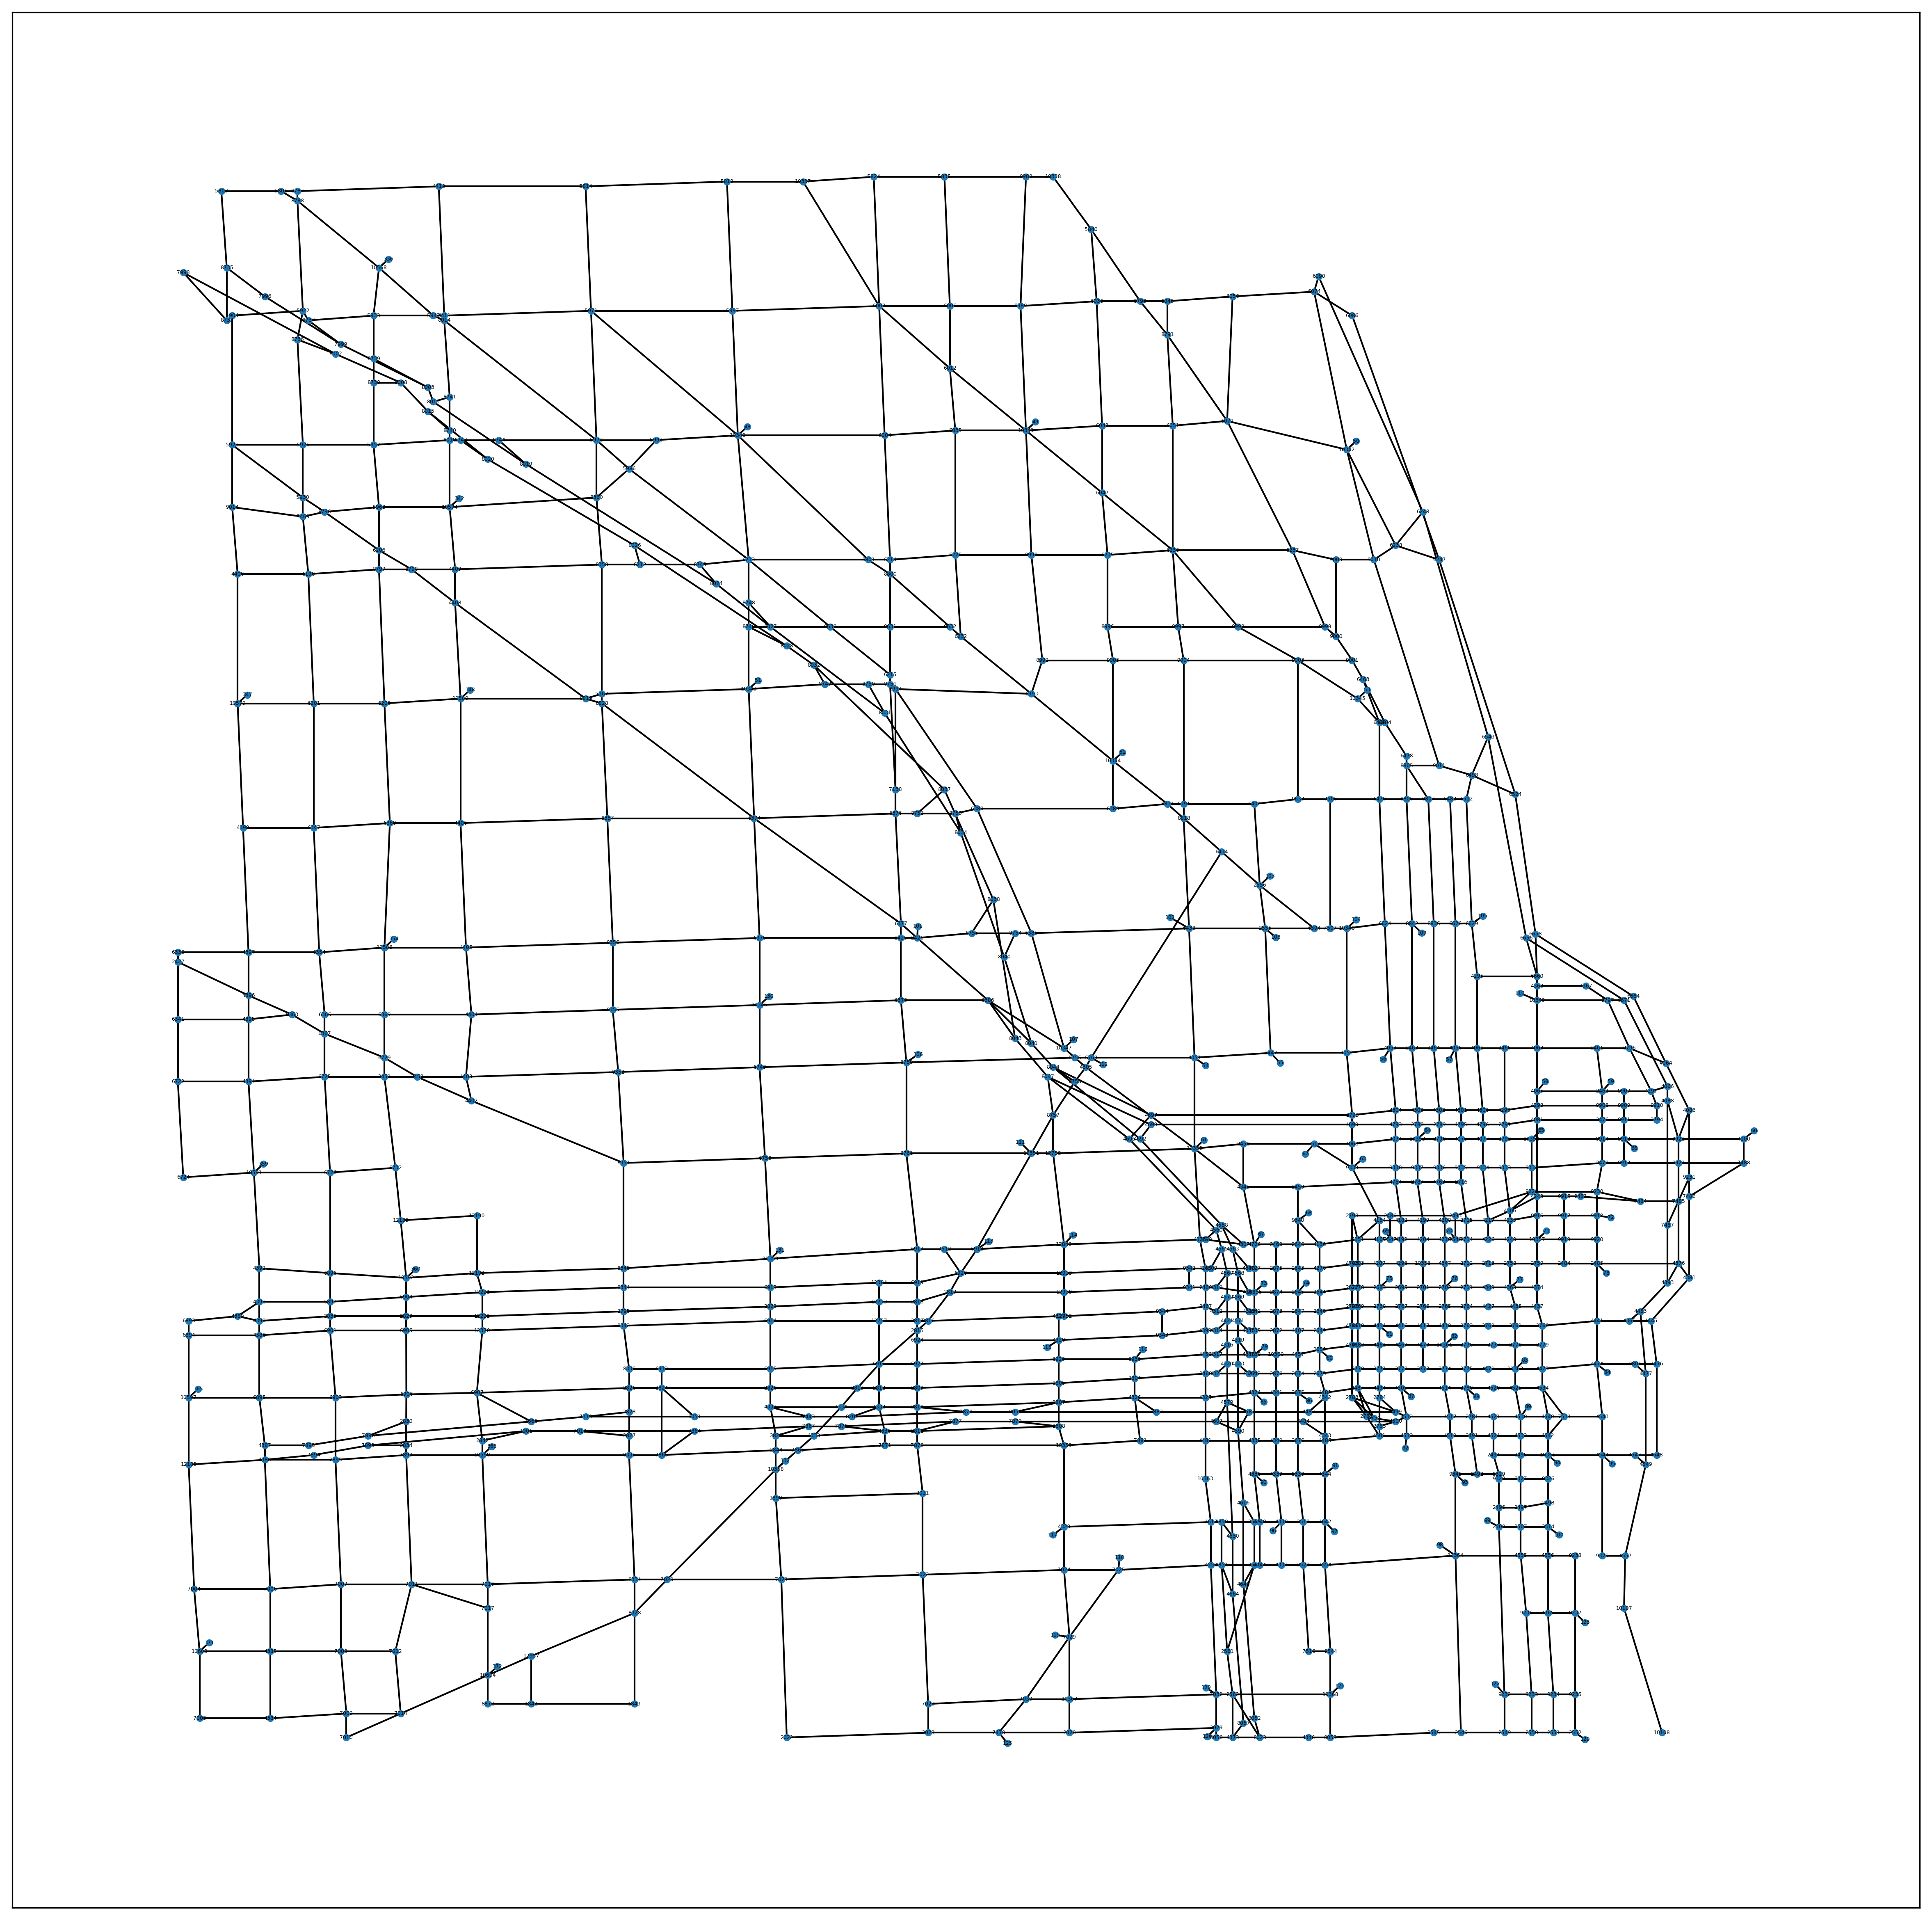

In [7]:
plt.figure(figsize=[20,20], dpi=300)
pos = dict(zip(nodes['NodeName'].to_numpy(), nodes[['x', 'y']].to_numpy()))
nx.draw_networkx(G, pos=pos, font_size=3, node_size=10)

Try Dijkstra method

In [8]:
nx.dijkstra_path(G, 5933, 2766)

[5933,
 8739,
 8003,
 8011,
 8019,
 8024,
 8027,
 8031,
 8034,
 8040,
 8041,
 8044,
 4692,
 4558,
 4563,
 4568,
 4311,
 10355,
 2641,
 2873,
 2647,
 2648,
 2769,
 2768,
 2767,
 2766]

# Define rider

## Rider attributes

|Attributes|Type|Note|
|---|---|---|
|ID|int|specified, unchanged, equals the index of rider_set|
|position|1D array|updated on every move|
|state|string|'idle', 'working' or 'stop'|
|speed|int|maxspeed when working, half maxspeed when idle|
|maxspeed|int|specified, unchanged|
|stop_time|float|0 when moving, increase when stop|
|total_time|float|count from matched (start working)|
|total_time_rec|list|record of total_time|
|next_node|int|determined by path or randomly chosen|
|nextnext_node|int|determined by path or randomly chosen|
|destination|int|can be merchant_node or customer_node, is None when idle|
|path|list|obtained by dijkstra method, is None when idle|
|closest_merchant_node|int|the closest merchant node ID (by distance)|
|merchant_node|int|is the closest merchant when working, is None when idle|
|merchant_node_set|int|set of all merchant nodes, unchanged|
|customer_nodes|list|updated on every arrival of destinations|
|matched_orders|list|updated on every arrival of destinations|
|if_matched|boolean|if the rider is matched, randomly chosen by the platform|
|if_matchable|boolean|if the rider lies in the matching area, it is matchable|
|dec_var|dict|contains r cR k t N q_bar|


## Rider behaviors
|Behaviors|Note|
|---|---|
|||

# Define platform


In [9]:
class platform:
    def __init__(self, r, cR, k, t):
        self.accumulated_order = []
        self.num_accumulated_order = 0
        self.accumulated_order_which_merchant = []
        self.r = r
        self.cR = cR
        self.k = k
        self.t = t
    
    def check_order_distance(self, generated_orders):
        # if the order is not at any of the merchant's delivery distance,
        # then remove this order
        
        to_be_removed_orders = []
        for i in generated_orders:
            for j in merchant_node_set:
                if np.linalg.norm(rider.get_node_xy(i) - rider.get_node_xy(j)) > self.cR:
                    try:
                        generated_orders.remove(i)
                    except:
                        None
        return generated_orders
        
    def acquire_order(self, q):
        num_generated_order_c = np.random.rand() * q * t_resolution * 2  # this is continuous ('_c'), not descrete
        self.num_accumulated_order += num_generated_order_c
        
        num_generated_order = int(self.num_accumulated_order - len(self.accumulated_order))
        
        generated_orders = list(np.random.choice(list(nodes['NodeName']), size=num_generated_order, replace=False))
        generated_orders = self.check_order_distance(generated_orders)
        self.accumulated_order.extend(generated_orders)

        generated_orders_which_merchant = [
            rider.get_closest_node(rider.get_node_xy(i), merchant_node_set) for i in generated_orders
        ]
        self.accumulated_order_which_merchant.extend(generated_orders_which_merchant)
    
    def remove_matched_order(self, matched_batches):
        for i in matched_batches.flatten():
            ind = self.accumulated_order.index(i)
            self.accumulated_order.remove(i)
            self.accumulated_order_which_merchant.remove(self.accumulated_order_which_merchant[ind])
        self.num_accumulated_order -= matched_batches.size
    
    def match(self, idle_rider_IDs, rider_set):
        rider_ID_set = [i.ID for i in rider_set]
        rider_index_df = pd.DataFrame(range(len(rider_ID_set)), index=rider_ID_set, columns=['ind'])
        
        matched_batches = []
        matched_rider_IDs = []
        
        for i in range(len(merchant_node_set)):
            # first find corresponding idle rider IDs
            merchant_node = merchant_node_set[i]
            idle_rider_IDs_this_merchant = []
            for idle_rider_ID in idle_rider_IDs:
                idle_rider = rider_set[rider_index_df.loc[idle_rider_ID, 'ind']]
                if idle_rider.closest_merchant_node==merchant_node:
                    idle_rider_IDs_this_merchant.append(idle_rider_ID)
            n_idle_riders_this_merchant = len(idle_rider_IDs_this_merchant)
            
            acc_ord_this_mer = np.array(self.accumulated_order)[np.array(self.accumulated_order_which_merchant)==merchant_node]
            
            num_required_riders_this_merchant = min(
                n_idle_riders_this_merchant,
                # number of accumulated orders for this merchant // k
                len(acc_ord_this_mer) // self.k
            )

            matched_rider_IDs_this_merchant = list(np.random.choice(
                idle_rider_IDs_this_merchant,
                num_required_riders_this_merchant,
                replace=False
            ))
            
            matched_batches_this_merchant = []
            for j in range(len(matched_rider_IDs_this_merchant)):
                matched_batches_this_merchant.append(acc_ord_this_mer[self.k*j:self.k*(j+1)])
            matched_batches_this_merchant = np.array(matched_batches_this_merchant)

            
            self.remove_matched_order(matched_batches_this_merchant)
            
            matched_batches.extend(matched_batches_this_merchant)
            matched_rider_IDs.extend(matched_rider_IDs_this_merchant)
        
        self.matched_batches = matched_batches
        
        return np.array(matched_batches), matched_rider_IDs  # their indexes are mutually matched
        

In [10]:
# Multi processing, but it is slower if only step one pace forward
def move_all_riders():
    # number of riders at each process
    N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
    n_process = N//N_each_process+1 if N%N_each_process != 0 else N//N_each_process

    params = []
    for i in range(n_process):
        params.append(
            [
                rider_set[i*N_each_process:(i+1)*N_each_process],
                t_resolution,
                matched_rider_IDs,
                matched_batches,
                dec_var
            ]
        )
    
    moved_rider_set = pool.starmap(func=rider.move_rider, iterable=params )
    return moved_rider_set


In [11]:
config_set = []
rider_set = []
N = 160
q_bar = 200
r = 2
cR = 5
k = 3
t = 0.005

Delta = cR
t_resolution = 0.001
match_period = t//t_resolution if t%t_resolution==0 else t//t_resolution+1

dec_var = {
    'r': r,
    'cR': cR,
    'k': k,
    't': t,
    'N': N,
    'q_bar': q_bar
}

merchant_node_set = [10343, 2766, 6907, 6237]

In [12]:
for i in range(N):
    config_i = {
        'ID': i,
        'initial_position': np.array([np.random.rand()*nodes['x'].max(), np.random.rand()*nodes['y'].max()]),
        'maxspeed': np.random.randint(10, 20)
    }
    rider_i = rider.rider(config_i, dec_var, merchant_node_set)
    
    config_set.append(config_i)
    rider_set.append(rider_i)

In [13]:
virtual_plat = platform(r, cR, k, t)

In [14]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_batch_set = []
p_set = []
pp_set = []

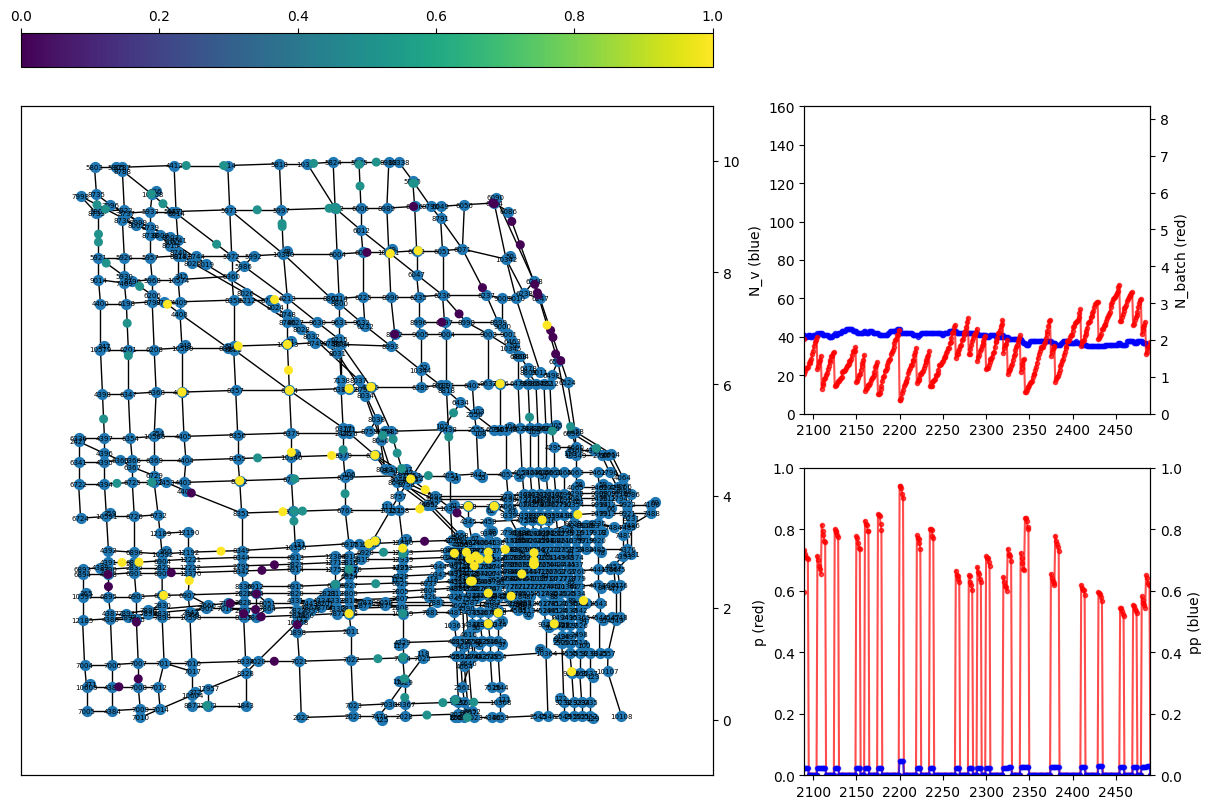

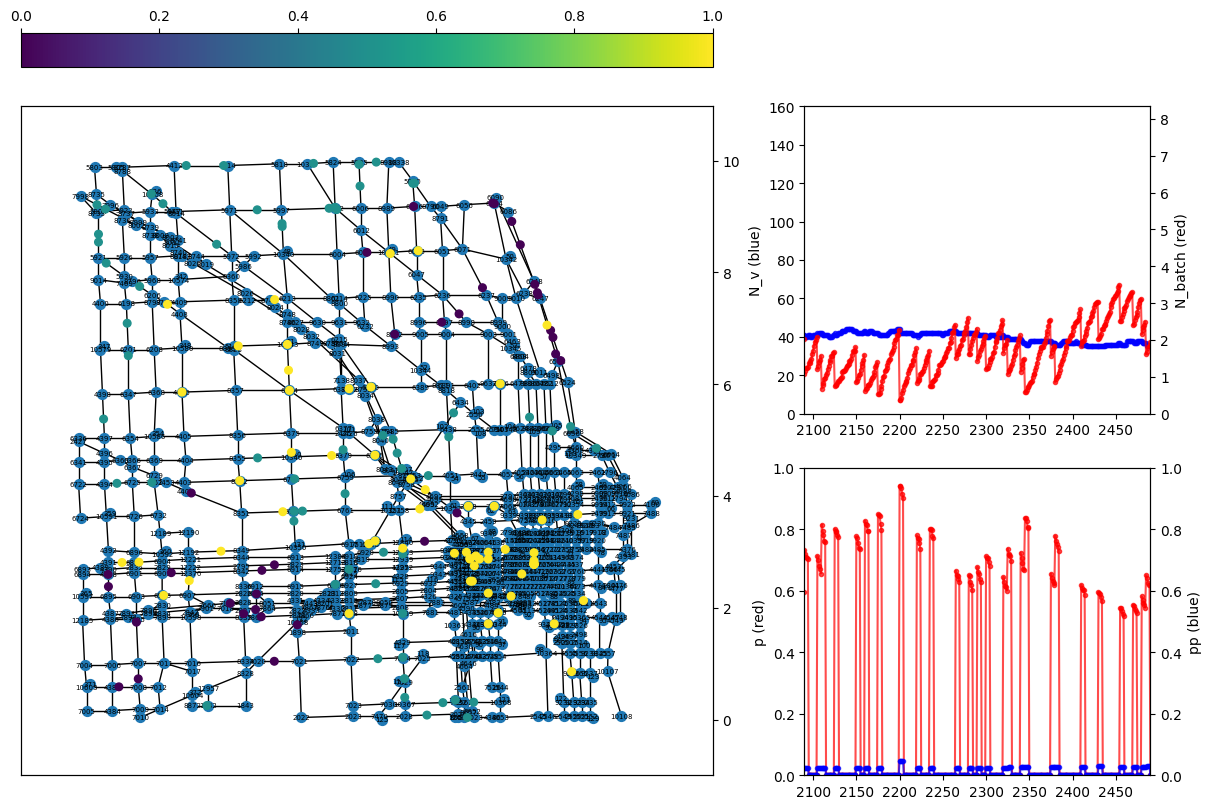

In [15]:
n_cpu = multiprocessing.cpu_count()
pool = Pool(processes=n_cpu)

# marking the x-axis and y-axis
fig = plt.figure(constrained_layout=True, figsize=[12, 8])
gs = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(gs[:2, :2])
ax0.set_xlim(-nodes['x'].max()*0.1, nodes['x'].max()*1.1)
ax0.set_ylim(-nodes['y'].max()*0.1, nodes['y'].max()*1.1)
ax = ax0.twinx()
ax.set_xlim(-nodes['x'].max()*0.1, nodes['x'].max()*1.1)
ax.set_ylim(-nodes['y'].max()*0.1, nodes['y'].max()*1.1)

ax2 = fig.add_subplot(gs[0, 2])
ax2.set_ylabel('N_v (blue)')
ax3 = ax2.twinx()
ax3.set_ylabel('N_batch (red)')
ax4 = fig.add_subplot(gs[1, 2])
ax4.set_ylabel('p (red)')
ax4.set_ylim([0, 1])
ax5 = ax4.twinx()
ax5.set_ylabel('pp (blue)')
ax5.set_ylim([0, 1])

# plt.tight_layout()

nx.draw_networkx(G, pos=pos, ax=ax0, node_size=50, font_size=5)

color = np.ones(N) * 0.5
scat = ax.scatter(np.random.randint(6, size=N), np.random.randint(6, size=N), s=30, c=color, vmin=0, vmax=1)
fig.colorbar(scat, ax=ax, location='top')
line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'r.-', alpha=0.7)
line5, = ax5.plot([], [], 'b.-', alpha=0.7)


while c < 2500:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle' and rider_set[i].if_matchable:
            idle_rider_IDs.append(rider_set[i].ID)
    
    q = q_bar * cR**2 / Delta**2
    virtual_plat.acquire_order(q)
    
    if c%match_period==0:
        matched_batches, matched_rider_IDs = virtual_plat.match(idle_rider_IDs, rider_set)
    
    num_matched_cust = matched_batches.size
    try:
        p = num_matched_cust / (num_matched_cust + virtual_plat.num_accumulated_order/k)
    except:
        # when there is no order
        p = 1
    try:
        pp = len(matched_rider_IDs) / len(idle_rider_IDs)
    except:
        pp = 1

    # move
#     rider_set = rider.move_rider(rider_set, t_resolution, matched_rider_IDs, matched_batches, dec_var)
    # for multiprocessing, uncomment the following lines
    moved_rider_set = move_all_riders()
    moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
    rider_set = moved_rider_set
    
    x_axis.append(c)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_batch_set.append(virtual_plat.num_accumulated_order/k)  # continuous
    p_set.append(p)
    pp_set.append(pp)
    
    
    if c%10==0:
        for i in range(N):
            if rider_set[i].state == 'idle' and rider_set[i].if_matchable:
                color[i] = 0
            elif rider_set[i].state == 'working' or rider_set[i].state == 'stop':
                color[i] = 1
            elif rider_set[i].state == 'idle' and rider_set[i].if_matchable==False:
                color[i] = 0.5
        scat.set_array(color)
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )
        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_batch_set)
        ax3.set_ylim([0, max(num_accumulated_batch_set)])
        line4.set_data(x_axis, p_set)
        ax4.set_ylim([0, 1])
        line5.set_data(x_axis, pp_set)
        ax5.set_ylim([0, 1])

        ax2.set_xlim([max(0, c-400), c])
        ax3.set_xlim([max(0, c-400), c])
        ax4.set_xlim([max(0, c-400), c])
        ax5.set_xlim([max(0, c-400), c])

        display.clear_output(wait=True)
        display.display(plt.gcf())
    
        fig.savefig('./res_img/%i.png'%c, dpi=125)
    c += 1
    